## The 2D diffusion equation on GPUs, in minutes

This notebook implements a solver for the 2D diffusion equation using an explicit finite difference scheme with fixed boundary values and a given initial value for the density.

In [1]:
# Some imports we will need below
import numpy as np
from devito import *

### Solver implementation

We start off creating a cartesian `Grid` representing our computational domain

In [2]:
nx, ny = 100, 100
grid = Grid(shape=(nx, ny))

To represent the density, we use a `TimeFunction` -- a scalar, discrete function encapsulating space- and time-varying data. We also use a `Constant` for the diffusion coefficient.

In [3]:
u = TimeFunction(name='u', grid=grid, space_order=2, save=200)
c = Constant(name='c')

The 2D diffusion equation is expressible as:

In [4]:
eqn = Eq(u.dt, c * u.laplace)

From which we derive our time-marching method -- at each timestep, we compute `u` at timestep `t+1`, which in the Devito language is represented by `u.forward`. Hence:

In [5]:
step = Eq(u.forward, solve(eqn, u.forward))

OK, it's time to let Devito generate code for our solver!

In [6]:
op = Operator([step])

We could now run the `Operator`, but let's first set up some initial conditions. Here, we place a constant-valued "ring" right in the middle of `u[0]`.

In [7]:
xx, yy = np.meshgrid(np.linspace(0., 1., nx, dtype=np.float32),
                     np.linspace(0., 1., ny, dtype=np.float32))
r = (xx - .5)**2. + (yy - .5)**2.
# Inserting the ring
u.data[0, np.logical_and(.05 <= r, r <= .1)] = 1.

Finally, we're ready to execute the `Operator`. We run it with a diffusion coefficient of 0.5 and for a carefully chosen `dt`. Unless specified otherwise, the simulation runs for `save=200` timesteps as specified in the definition of `u`.

In [8]:
stats = op.apply(dt=5e-05, c=0.5)

Operator `Kernel` run in 0.01 s


### Initial condition and snapshots after 100 and 200 timesteps

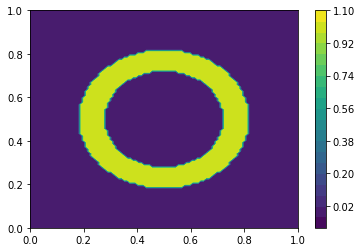

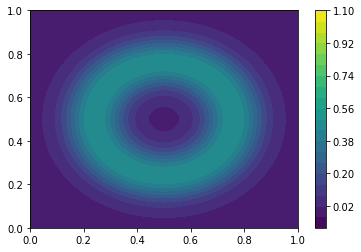

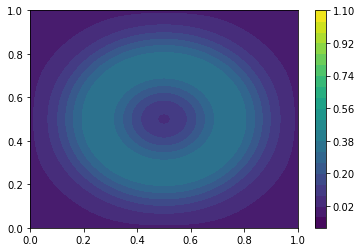

(None, None, None)

In [13]:
from examples.cfd.example_diffusion import animate
animate(u.data[0]), animate(u.data[99]), animate(u.data[199])

### GPU-parallel solver
Let's generate a GPU implementation of the same solver. It can't be any easier than

In [10]:
# Equivalently, run with the env var DEVITO_PLATFORM=nvidiaX
configuration['platform'] = 'nvidiaX'
configuration['openmp'] = 1

op = Operator([step])

And that's it, pretty much. We can now run it exactly like we did before

In [11]:
# Uncomment if an nvidiaX GPU is at our disposal
# stats = op.apply(dt=5e-05, c=0.5)

We can see there is indeed a big performance difference between the two runs. What did Devito exactly create? We can inspect `op`

In [12]:
print(op)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float c, const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, struct profiler * timers, const int x_M, const int x_m, const int y_M, const int y_m)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;
  #pragma omp target enter data map(to: u[0:u_vec->size[0]][0:u_vec->size[1]][0:u_vec->size[2]])
  for (int time = time_m; time <= time_M; time += 1)
  {
    struct timeval start_section0, end_section0;
    gettimeofday(&start_section0, NULL);
    /* Begin section0 */
    #pragma omp target teams distribute parallel for collapse(2)
    